<a href="https://colab.research.google.com/github/ricyoung/cs689/blob/master/HW5_fastai_resnet_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST KANG NN
ryoung


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import random

check to make sure a gpu is attached

In [0]:
!nvidia-smi

Sat May  2 01:10:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

grab fasti ai / pytouch


In [0]:
from fastai.vision import *

### Data

In [0]:
path = untar_data(URLs.MNIST)

# baby mnist
# path = untar_data(URLs.MNIST_TINY)


In [0]:
# this grabs the image data from folder and forces it to 1 layer ( conver mode l = gray scale not rbg)
il = ImageList.from_folder(path, convert_mode='L')

In [0]:
#cheecks a random image path
r = random.randint(1,10000) 
il.items[r]

PosixPath('/root/.fastai/data/mnist_png/training/6/21061.png')

r=2070


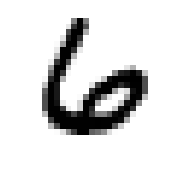

In [0]:
defaults.cmap='binary'
print("r=" + str(r))
# print(il)
il[r].show()

In [0]:
# path = untar_data(URLs.MNIST_TINY)

path = untar_data(URLs.MNIST)

In [0]:
# data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)

sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
# (path/'training').ls()

In [0]:
ll = sd.label_from_folder()

In [0]:
x,y = ll.train[r]

# x.show()
# print("number =" + str(y) )

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

[databunch ](https://https://docs.fast.ai/basic_data.html)

In [0]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

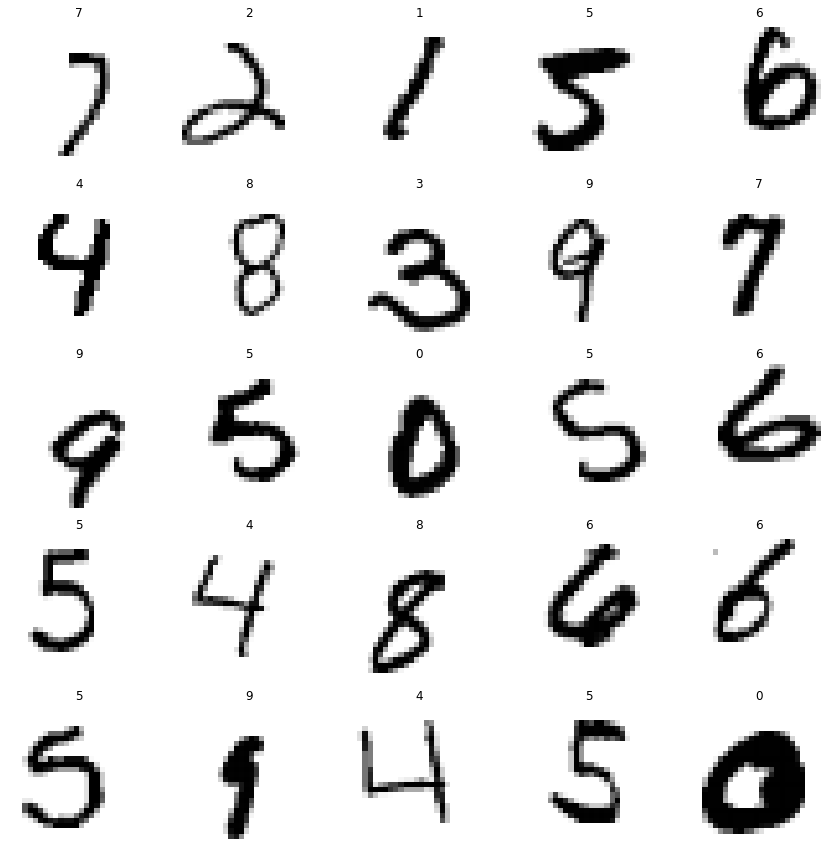

In [0]:
data.show_batch(figsize=(12,12))

In [0]:
x,y = data.train_ds[0]

In [0]:
# def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
# plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
# xb,yb = data.one_batch()
# xb.shape,yb.shape

In [0]:
# data.show_batch(rows=3, figsize=(5,5))

In [0]:
# xb = xb.cuda()

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))# model(xb).shape

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))


this is just an short hand for of 

input is 28x28

--
    conv2(1, 8), ( 2d con - make this a 
    res_block(8),
    
    conv2(8, 16),
    res_block(16),
    
    conv2(16, 32),
    res_block(32),
    
    conv2(32, 16),
    res_block(16),
    
    conv2(16, 10),

    this just picks a the best 0 to 9
    Flatten()

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

[learner](https://docs.fast.ai/basic_train.html)

In [0]:
learn = Learner(    data,
                    model,
                    loss_func = nn.CrossEntropyLoss(),
                    # opt_func = Adam,
                    # models.resnet18,
                    metrics=accuracy
                )

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


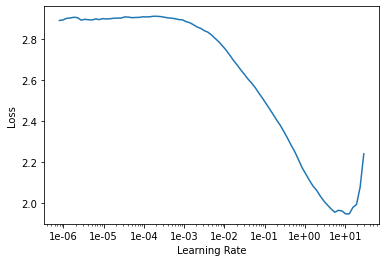

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.325745,0.183993,0.966200,00:20
1,0.145659,0.098855,0.969900,00:20
2,0.111282,0.118135,0.959900,00:20
3,0.079656,0.079926,0.975900,00:20
4,0.062644,0.062885,0.980300,00:19
5,0.060005,0.043296,0.985000,00:19
6,0.052928,0.045645,0.985700,00:19
7,0.047667,0.031366,0.989800,00:19
8,0.043001,0.036919,0.988100,00:19
9,0.034730,0.024722,0.992400,00:19


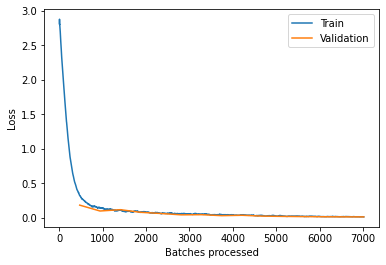

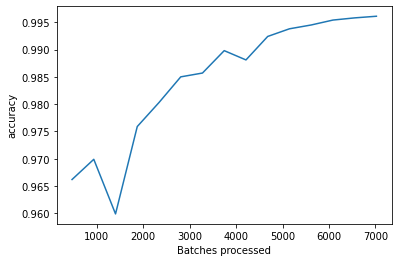

In [0]:
learn.fit_one_cycle(15, max_lr=0.02)
learn.recorder.plot_losses()
learn.recorder.plot_metrics()
#lr = .08
#99% after 7 epoch
#99.5 afterr 10 epoch

#lr = .06 
#99% after 18


In [0]:

print(learn.summary())


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## Test - results :-)




```
label
predicted
```



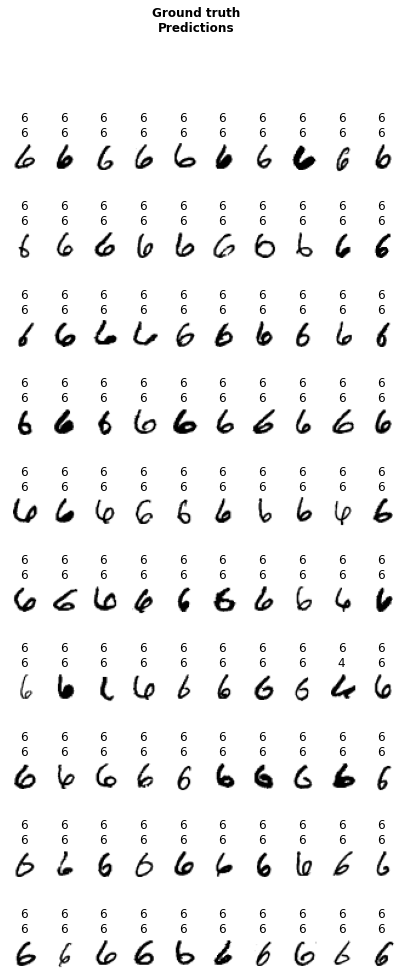

In [0]:
learn.show_results(rows=10,figsize=(7,16))

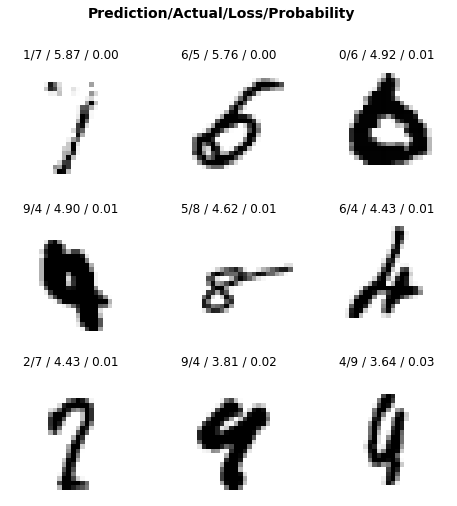

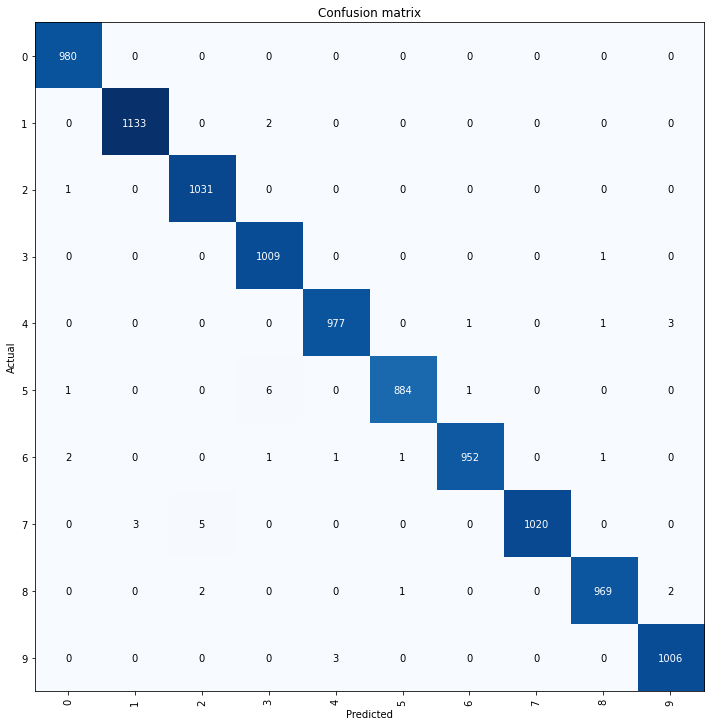

In [0]:
#the misfits
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(8,8))
interp.plot_confusion_matrix(figsize=(10,10))
#come on - those are not even numbers I can understand - WTF